In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [53]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, smooth_boundary=False, kernel_size=15):
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(img_bin, connectivity=8, ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    if fill_holes:
        bkg_locs = np.where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)
        
    return largest_mask

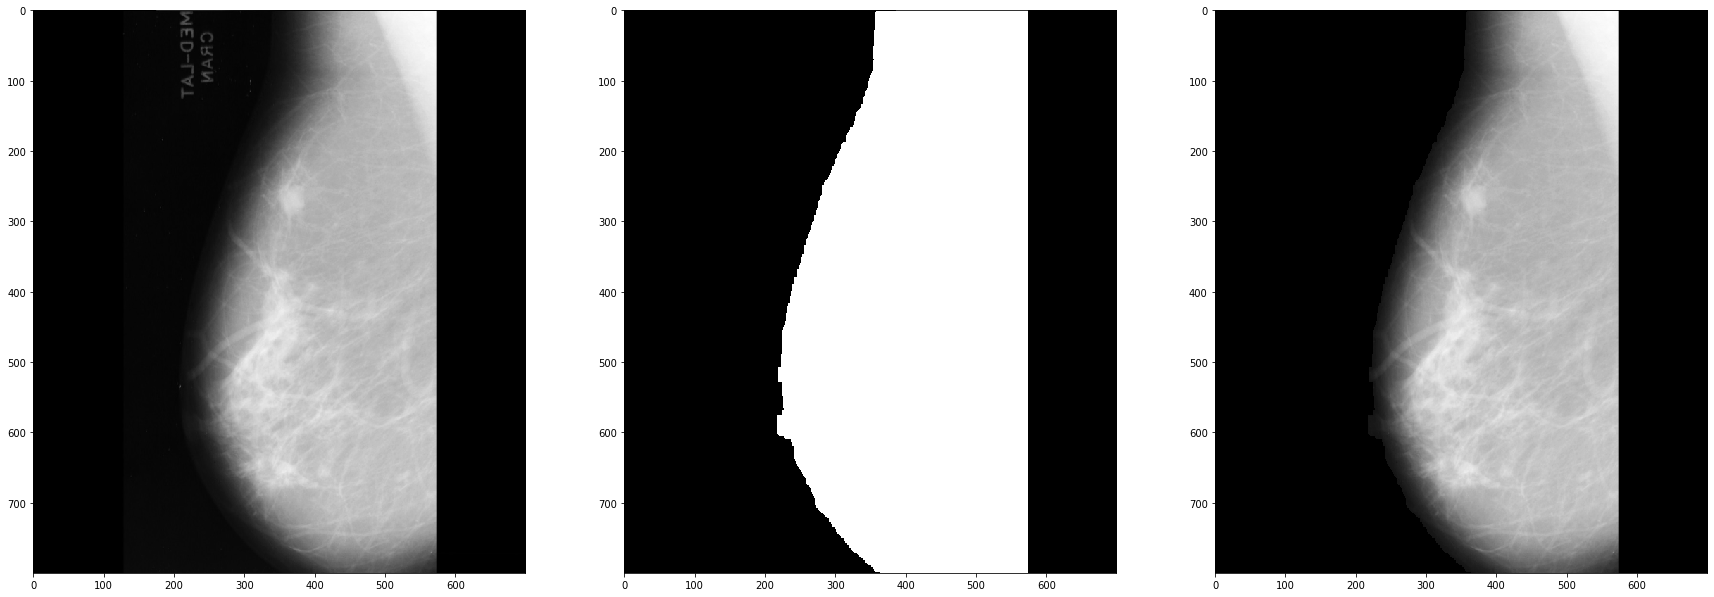

In [144]:
img = cv2.imread('cancer.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (700, 800), interpolation = cv2.INTER_AREA)
# convert image to greyscale
global_threshold = 18
_, mammo_binary = cv2.threshold(img, global_threshold, maxval=255, type=cv2.THRESH_BINARY)
mask = select_largest_obj(mammo_binary, lab_val=255, fill_holes=False, smooth_boundary=True, kernel_size=15) 
final = cv2.bitwise_and(img, mask)
cv2.imshow('original', img)
cv2.imshow('final', final)
cv2.waitKey(0)
cv2.destroyAllWindows()
fig,axes = plt.subplots(1, 3)
fig.set_size_inches([30, 40])
axes[0].imshow(img, cmap='gray')
axes[1].imshow(mask, cmap='gray')
axes[2].imshow(final, cmap='gray')

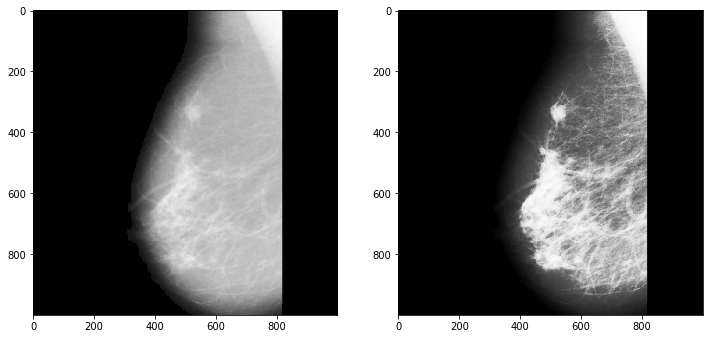

In [140]:
muscle = cv2.equalizeHist(final)
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(final, cmap='gray')
axes[1].imshow(muscle, cmap='gray')

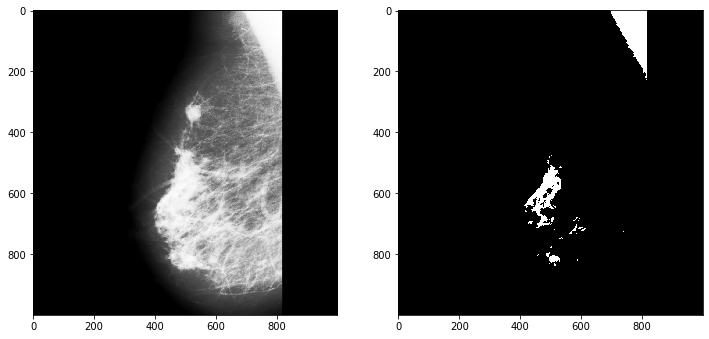

In [141]:
pect_high_inten_thres = 240  # <<= para to tune!
_, muscle_fucked = cv2.threshold(muscle, pect_high_inten_thres, 
                                     maxval=255, type=cv2.THRESH_BINARY)
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(muscle, cmap='gray')
axes[1].imshow(muscle_fucked, cmap='gray')

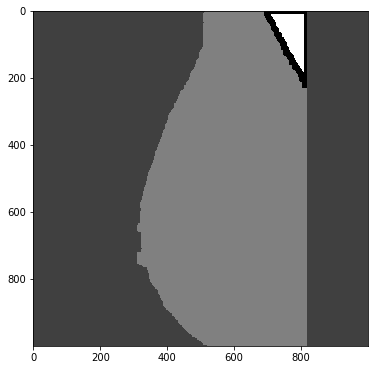

In [142]:
# Markers image for watershed algo.
pect_marker_img = np.zeros(muscle_fucked.shape, dtype=np.int32)
# Sure foreground.
pect_mask_init = select_largest_obj(muscle_fucked, lab_val=255, 
                                    fill_holes=True, smooth_boundary=False)
kernel_ = np.ones((3, 3), dtype=np.uint8)  # <<= para to tune!
n_erosions = 7  # <<= para to tune!
pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, iterations=n_erosions)
pect_marker_img[pect_mask_eroded > 0] = 255
# Sure background - breast.
n_dilations = 7  # <<= para to tune!
pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, iterations=n_dilations)
pect_marker_img[pect_mask_dilated == 0] = 128
# Sure background - background.
pect_marker_img[mask == 0] = 64
# plot.
fig,ax = plt.subplots()
fig.set_size_inches([6, 9])
ax.imshow(pect_marker_img, cmap='gray')

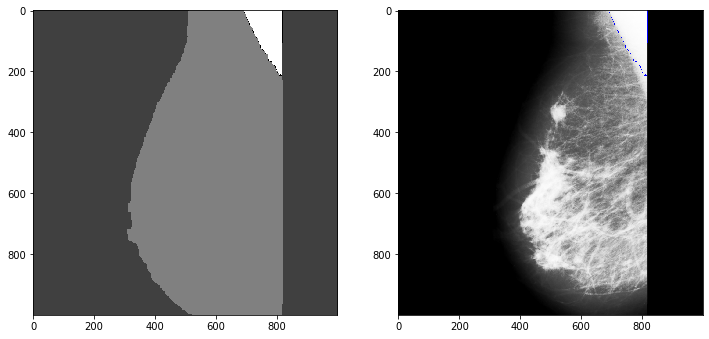

In [146]:
mammo_breast_equ_3c = cv2.cvtColor(muscle, cv2.COLOR_GRAY2BGR)
cv2.watershed(mammo_breast_equ_3c, pect_marker_img)
pect_mask_watershed = pect_marker_img.copy()
mammo_breast_equ_3c[pect_mask_watershed == -1] = (0, 0, 255)
pect_mask_watershed[pect_mask_watershed == -1] = 0
fig,axes = plt.subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(pect_mask_watershed, cmap='gray')
axes[1].imshow(mammo_breast_equ_3c)

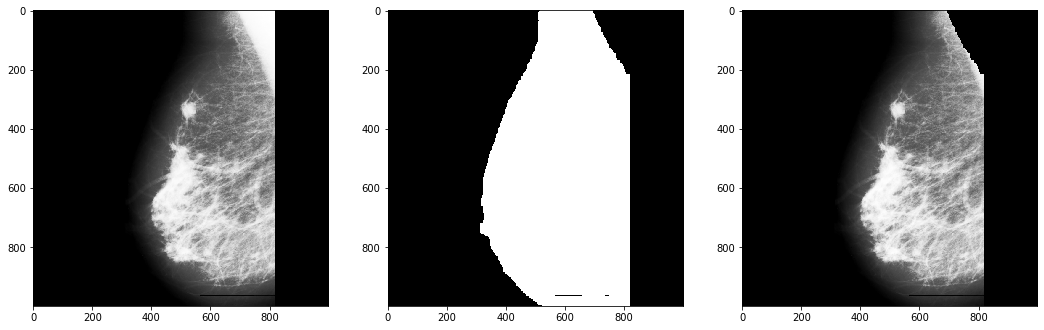

In [149]:
breast_only_mask = pect_mask_watershed.astype(np.uint8)
breast_only_mask[breast_only_mask != 128] = 0
breast_only_mask[breast_only_mask == 128] = 255
kn_size = 25  # <<= para to tune!
kernel_ = np.ones((kn_size, kn_size), dtype=np.uint8)
breast_only_mask_smo = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, kernel_)
mammo_breast_only = cv2.bitwise_and(muscle, breast_only_mask_smo)
fig,axes = plt.subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(muscle, cmap='gray')
axes[1].imshow(breast_only_mask_smo, cmap='gray')
axes[2].imshow(mammo_breast_only, cmap='gray')